# Analysis of testData2

**Author**: Jacopo Ventura

**Date**: 23rd October 2017

A predictive model for the feature $t$ is build through the following steps:

1. descriptive statistics of data and first plots to get insights
2. check linear correlation between features
3. separate training and test sets
4. train few machine learning algorithms and select the best one 
5. test the algorithm on the test dataset


In [1]:
# Import packages for data analysis
import os    # OS module provides the interface with the operating system and allows to use it
import tarfile
from six.moves import urllib
import pandas as pd     # Pandas: python library for large data manipulation and analysis. 
                        # Dataset will be saved as Pands dataset
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

# this command is very important in Jupyter: figures must be showed directly in the notebook!!!
%matplotlib inline

# disable warnings
import warnings
warnings.filterwarnings("ignore")


# step 1: acquire dataset
data_path='C:/Users/jacopo/Desktop/schaeffler/testData2.csv'
dataset = pd.read_csv(data_path,sep=';')   # dataset as pandas dataset

print('Overview of the dataset: size of dataset and type of data:\n')
dataset.info()

Overview of the dataset: size of dataset and type of data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
a    1000 non-null float64
b    1000 non-null float64
c    1000 non-null float64
d    1000 non-null float64
e    1000 non-null int64
f    1000 non-null int64
t    1000 non-null float64
dtypes: float64(5), int64(2)
memory usage: 54.8 KB


### Step 1: descriptive statistics of data and first plots

We now get the first insights on data by performing descriptive statistics.

In [2]:
print('\nDescriptive statistics of the dataset:')
dataset.describe()


Descriptive statistics of the dataset:


,a,b,c,d,e,f,t
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000
mean,170.114480,4550.159770,40.401890,172.13218,2.97300,3.571000,57.256710
std,63.522191,1594.045709,22.744745,76.36400,1.43399,2.288711,35.173018
min,60.110000,1615.130000,0.080000,40.03000,1.00000,0.000000,-164.020000
25%,115.222500,3185.995000,20.187500,105.71000,2.00000,2.000000,41.805000
50%,169.555000,4491.455000,39.910000,172.44000,3.00000,3.500000,52.365000
75%,224.187500,5911.387500,60.512500,238.74500,4.00000,6.000000,63.987500
max,279.540000,7483.760000,79.830000,299.89000,5.00000,7.000000,305.530000


The dataset consists of 1000 instances composed by 6 attributes ( $a$ , $b$ , $c$, $d$, $e$, $f$) and the target attribute  $t$. Moreover, **the dataset is complete**, meaning that no missing data (NaN) are present.

The target feature $t$ is continuous numerical. Therefore, predicting $t$ is a **regression task**.

It is very imporant to observe that the features $e$ and $f$ are numerical discrete variables. We have no information if these features are categorical or numerical. However, it is reasonable to assume both $e$ and $f$ numerical discrete. In fact, $e$ could represent a score / rank as it assumes integer values in the interval $[1,5]$. Furthermore, $f$ could represent a quantity as it assumes integert values in the range $[0,7]$. Frequencies of values are showed in the plots here below.

Finally, features $e$ and $f$ are *three orders of magnitude* lower than feature $b$.

Counter({5: 209, 1: 209, 2: 205, 3: 199, 4: 178})
Counter({3: 140, 7: 139, 1: 127, 5: 123, 2: 121, 6: 121, 4: 117, 0: 112})


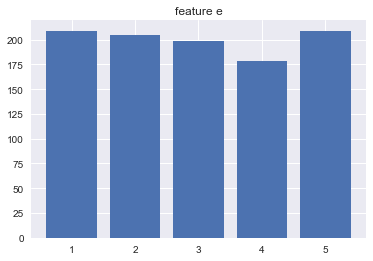

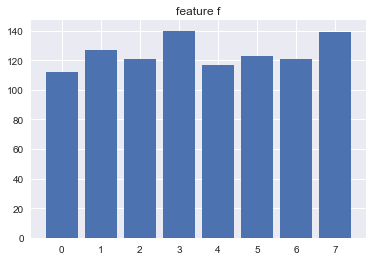

In [3]:
# frequencies of discrete numerical values
import collections

# frequecies of discrete numerical feature
def freq_discrete_feature(feature):
    
    feature_freq = collections.Counter(feature)
    print(feature_freq)
    
    dim = len(feature_freq)
    dim_0 = 0
    if feature_freq[0]==0:
        dim = dim + 1
        dim_0 = 1
        
    # create output
    feature_freq_ordered = [feature_freq[i] for i in range(dim_0,dim)]
    feature_ordered = [i for i in range(dim_0,dim)]
    
    return feature_ordered, feature_freq_ordered

feature_e_ordered, feature_e_freq_ordered = freq_discrete_feature(dataset['e'].values) 
feature_f_ordered, feature_f_freq_ordered = freq_discrete_feature(dataset['f'].values) 



plt.bar(feature_e_ordered,feature_e_freq_ordered)
plt.title('feature e')
plt.xticks(feature_e_ordered) 
plt.show()

plt.bar(feature_f_ordered,feature_f_freq_ordered)
plt.title('feature f')
plt.xticks(feature_f_ordered) 
plt.show()

### Step 2: Check linear correlation through the Pearson's r coefficient

Let us now check the linear correlation between variables using Pearsons' r. 

As we can observe from the correlation matrix, **features $a$ and $b$ are strongly correlated to each others**.

Pearsons r correlation coefficient for t:
t    1.000000
b    0.305322
a    0.304193
e    0.025271
d    0.022822
f   -0.075959
c   -0.277344
Name: t, dtype: float64
Display correlation matrix


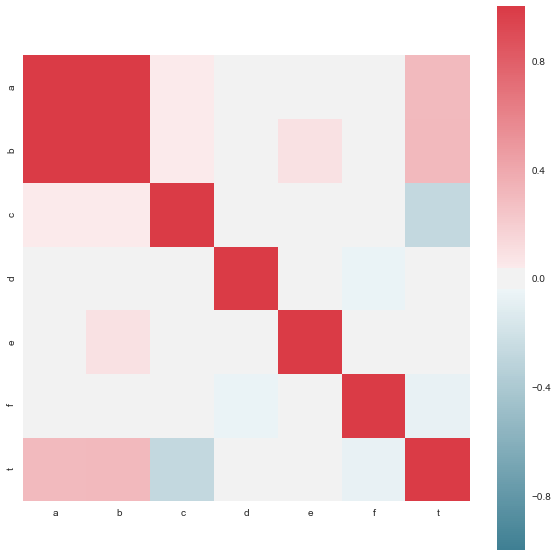

In [4]:
# generate scatter matrix
from pandas.plotting import scatter_matrix

# check linear correlation through Pearson's r
print('Pearsons r correlation coefficient for t:')
corr_matrix = dataset.corr()
print(corr_matrix["t"].sort_values(ascending=False))

print('Display correlation matrix')
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, 
            mask=np.zeros_like(corr_matrix, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Scatter matrix of data:


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023ADD28A710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000023ADE5F2748>]], dtype=object)

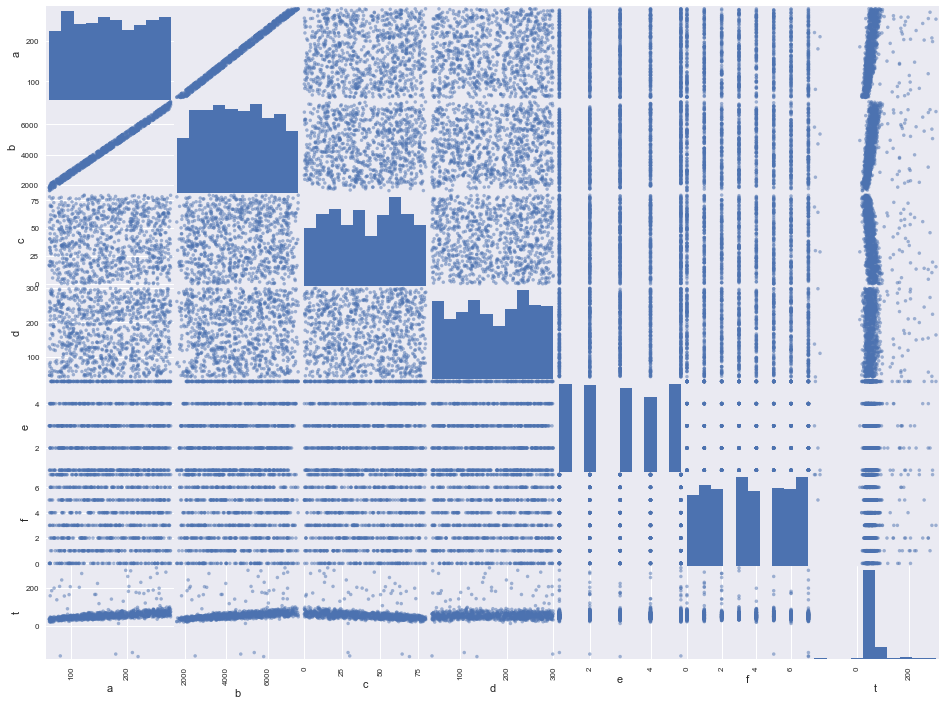

In [5]:
print('Scatter matrix of data:')
scatter_matrix(dataset, figsize=(16, 12))

As showed in the scatter matrix, **features $a$ and $b$ are linearly correlated**. 

The Principal component analysis (PCA) must be therefore applied to generate a new feature along the principal axis. 

variance ration along the principal axis:
[ 0.99998719]


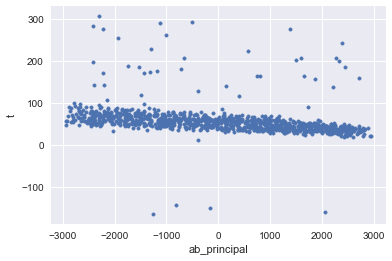

In [6]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components = 1).fit(dataset[['a','b']])

print('variance ration along the principal axis:')
print(pca.explained_variance_ratio_)

data_transformed = pca.transform(dataset[['a','b']])

plt.scatter(data_transformed,dataset['t'],marker='.')
plt.xlabel('ab_principal')
plt.ylabel('t')
plt.show()

The dataset is now modified. The new feature created with PCA is included instead of $a$ and $b$.

Pearsons r correlation coefficient for t:
t               1.000000
e               0.025271
d               0.022822
f              -0.075959
c              -0.277344
ab_principal   -0.305323
Name: t, dtype: float64
Display correlation matrix


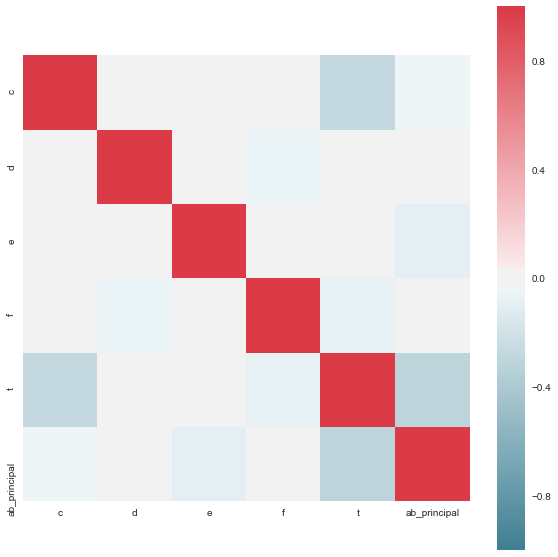

In [10]:
dataset_reduced = dataset.drop(['a','b'],axis=1)
dataset_reduced['ab_principal'] = data_transformed
dataset_reduced.describe()

# check linear correlation through Pearson's r
print('Pearsons r correlation coefficient for t:')
corr_matrix = dataset_reduced.corr()
print(corr_matrix["t"].sort_values(ascending=False))

print('Display correlation matrix')
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, 
            mask=np.zeros_like(corr_matrix, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Now independent variables are not correlated to each others. Strongest correlations are observed between $t$ and $c$ and between $t$ and the new feature $ab$.

### Step 3: separate test and training datasets

From the original dataset, training and test datasets are created. Test data is 20% of the original dataset (random sampling).

In [11]:
# Generation of train and test dataset by random sampling
from sklearn.cross_validation import train_test_split
 
Features_X = dataset_reduced[['ab_principal','c','d','e','f']]
Label_Y = dataset_reduced['t']
train_Features, test_Features, train_Label, test_Label = train_test_split(Features_X, 
                                                                            Label_Y, 
                                                                            test_size=0.2,
                                                                            random_state=42)

print(len(train_Features), "train +", len(test_Features), "test")

800 train + 200 test


D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler_Feature = MinMaxScaler().fit(train_Features)
train_Features_scaled = scaler_Feature.transform(train_Features)

### Step 4: training of Machine Learning models

The following Machine Learning models are trained:

1. Linear regression
2. Support Vector Regression
3. Random Forest
4. kNN

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# options for cross validation
score_cross_val = "neg_mean_squared_error"
N_split = 10

# function to display results from cross validation
def display_scores(scores):
    print('Performance measure for cross validation: root mean squared error RMSE')
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [14]:
# 1: Linear regression
from sklearn.linear_model import LinearRegression

# train linear regression
lin_reg = LinearRegression()
lin_reg.fit(train_Features_scaled, train_Label)

# cross validation on the training dataset
scores = cross_val_score(lin_reg,train_Features_scaled,
                         train_Label,
                         scoring=score_cross_val, 
                         cv=N_split)

lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

print('\nLinear regression coefficients:')
print(lin_reg.coef_)

Performance measure for cross validation: root mean squared error RMSE
Mean: 29.6999437001
Standard deviation: 9.65852569994

Linear regression coefficients:
[-43.13866307 -34.21668166   0.05501352   1.66518245  -5.43037794]


In [15]:
# 2: SVM regression
from sklearn.svm import SVR
svr_reg = SVR(kernel='linear',
              C = 100,
              gamma = 'auto')

svr_reg.fit(train_Features_scaled, train_Label)

# cross validation on the training dataset
scores = cross_val_score(svr_reg,train_Features_scaled,
                         train_Label,
                         scoring=score_cross_val, 
                         cv=N_split)

tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Performance measure for cross validation: root mean squared error RMSE
Mean: 29.6033792594
Standard deviation: 10.297127014


In [16]:
# 3: Random Forest
from sklearn.ensemble import RandomForestRegressor

# train Random Forest
forest_reg = RandomForestRegressor(n_estimators = 100,
                                   max_depth=None,   
                                   min_weight_fraction_leaf=0.0, 
                                   max_features='auto', 
                                   bootstrap=True
                                  )


forest_reg.fit(train_Features_scaled, train_Label)


# cross validation on the training dataset
scores = cross_val_score(forest_reg,train_Features_scaled,
                         train_Label,
                         scoring=score_cross_val, 
                         cv=N_split)

forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Performance measure for cross validation: root mean squared error RMSE
Mean: 33.2320408145
Standard deviation: 8.58397145171


In [17]:
# 4: kNN
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=20)

knn_reg.fit(train_Features_scaled, train_Label)

# cross validation on the training dataset
scores = cross_val_score(knn_reg,train_Features_scaled,
                         train_Label,
                         scoring=score_cross_val, 
                         cv=N_split)

forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Performance measure for cross validation: root mean squared error RMSE
Mean: 30.625395175
Standard deviation: 9.24327513793


SVM and Linear regression have close performance. The selected Machine Learning model is Linear regression since coefficients provide useful information on how each feature influence the dependent variable and feature scaling is not required. 

### Step 5: final model and validation on the Test set

In [18]:
# train linear regression (unscaled features)
lin_reg_final = LinearRegression().fit(train_Features, train_Label)

y_predicted = lin_reg_final.predict(train_Features)

# cross validation on the training dataset
scores = cross_val_score(lin_reg_final,train_Features,
                         train_Label,
                         scoring=score_cross_val, 
                         cv=N_split)

lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)


print('\nPerformance (RMSE) on the train dataset:')
print(np.sqrt(mean_squared_error(train_Label,y_predicted)))


# test on the test dataset
y_predicted_test = lin_reg_final.predict(test_Features)

print('\nPerformance (RMSE) on the test dataset:')
print(np.sqrt(mean_squared_error(test_Label,y_predicted_test)))


Performance measure for cross validation: root mean squared error RMSE
Mean: 29.6999437001
Standard deviation: 9.65852569994

Performance (RMSE) on the train dataset:
30.9496684333

Performance (RMSE) on the test dataset:
34.9668634393


The RMSE on the test dataset is slightly worse than the RMSE on the train dataset.

From the coefficient analysis (scaled features), we can observe that the features $ab$ and $c$ have the major influence on the target feature $t$.